# Description
## Why we choose two Datasets:
We selected the VQA and VizWiz datasets for their complementary strengths. The VQA dataset provides a broad range of everyday scenes and diverse question types, serving as a strong benchmark for general tasks. The VizWiz dataset features real-world, noisy images from visually impaired users, testing the model’s robustness. This combination improves generalization by exposing the model to both standard and challenging scenarios, aligning well with our goal of building a versatile and reliable VQA system.
## Summary
  Analyzing the composition of the dataset helps us understand the variety and complexity of questions, which is crucial for designing an effective model.  In this section, we define functions to explore and visualize the datasets using pie charts, histograms, and word clouds. Pie Chart can provide a clear view of the distribution of different question types in the dataset. Histogram shows the distribution of the answer type. and Word Cloud highlights the most common words in the questions, reflecting key content characteristics like color, description, and category.


These visualizations give us valuable insights into the dataset, guiding our model design and improvements.
### VizWiz
  For the VizWiz dataset, we will create four visualizations:
  - A pie chart of answer types.
  - A pie chart showing the distribution of answerable vs. unanswerable questions.
  - A histogram of answerable questions.
  - A word cloud of the most common words.
   
### VQA Dataset
  For the VQA dataset, we will create four visualizations:
  - A pie chart of answer types.
  - A word cloud of the most common words.

These plots provide insights into the dataset’s composition and key features.

In [24]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
!pip install Levenshtein
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-njq3ao9l
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-njq3ao9l
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


# Import Libraries

In [26]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# For data preprocessing, we will use Counter, train_test_split, Levenshtein distance, Python Image Library and OneHotEncoder
from collections import Counter
import Levenshtein as lev
from PIL import Image
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import pickle # For saving and loading the preprocessed data, we will use pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import clip
from torch.utils.data import Dataset, DataLoader
import requests # For taking the image from the URL, we will use requests
from sklearn.metrics import average_precision_score

import json

# Path Configure

In [27]:
#this is path for clip based model training on Vizwiz Dataset
INPUT_PATH = '/content/drive/MyDrive/9444clip/comp9444'
ANNOTATIONS = INPUT_PATH + '/Annotations/Annotations'
TRAIN_PATH = INPUT_PATH + '/train/train'
VALIDATION_PATH = INPUT_PATH + '/val/val'
ANNOTATIONS_TRAIN_PATH = ANNOTATIONS + '/train.json'
ANNOTATIONS_VAL_PATH = ANNOTATIONS + '/val.json'
OUTPUT_PATH = '/content/drive/MyDrive/9444clip/OUTPUT/'
ANSWER_SPACE = 0 # Will be configured later when we build the vocab using the methodology described in the paper
MODEL_NAME = "ViT-L/14@336px" # This is the backbone of the CLIP model

# Using accelerated computing if available
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", DEVICE)

Device:  cuda


# Function Define

In [28]:
def read_dataframe(path):
    """
    Reads the JSON file and returns a dataframe with the required columns (image, question, answers, answer_type, answerable)

    Parameters:
        path (str): Path to the JSON file

    Returns:
        df (pandas.DataFrame): Dataframe with the required columns
    """
    df = pd.read_json(path)
    df = df[['image', 'question', 'answers', 'answer_type', 'answerable']]
    return df
def split_train_valid_test(dataframe, train_size=0.7, valid_size=0.2, test_size=0.1):
    # Step 1: Split into train and remaining sets (remaining will be split into valid and test sets)
    train, remaining = train_test_split(dataframe, test_size=(1 - train_size), random_state=42, stratify=dataframe[['answer_type']])
    # Step 2: Split remaining set into validation and test sets (valid_size is 2/3 of remaining, test_size is 1/3)
    valid, test = train_test_split(remaining, test_size=test_size/(test_size + valid_size), random_state=42, stratify=remaining[['answer_type']])
    return train, valid, test
def split_train_test(dataframe, test_size = 0.05):
    """
    Splits the dataframe into train and test sets

    Parameters:
        dataframe (pandas.DataFrame): Dataframe to be split

    Returns:
        train (pandas.DataFrame): Train set
        test (pandas.DataFrame): Test set
    """
    train, test = train_test_split(dataframe, test_size=test_size, random_state=42, stratify=dataframe[['answer_type', 'answerable']])
    return train, test

def plot_histogram(dataframe, column):
    """
    Plots the histogram of the given column

    Parameters:
        dataframe (pandas.DataFrame): Dataframe to be plotted
        column (str): Column to be plotted

    Returns:
        None
    """
    plt.hist(dataframe[column])
    plt.title(column)
    plt.show()

def plot_pie(dataframe, column):
    """
    Plots the pie chart of the given column

    Parameters:
        dataframe (pandas.DataFrame): Dataframe to be plotted
        column (str): Column to be plotted

    Returns:
        None
    """
    value_counts = dataframe[column].value_counts()
    plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%')
    plt.title(column)
    plt.show()

def plot_wordcloud(dataframe, column):
    """
    Plots the wordcloud of the given column

    Parameters:
        dataframe (pandas.DataFrame): Dataframe to be plotted
        column (str): Column to be plotted

    Returns:
        None
    """
    text = " ".join([word for word in dataframe[column]])

    wordcloud = WordCloud(width = 800, height = 800,
                    background_color ='white',
                    min_font_size = 10).generate(text)

    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.show()

def explore_dataframe_vqa(dataframe):
    """
    Explores the dataframe (EDA) by plotting the pie charts, histograms and wordclouds of the columns

    Parameters:
        dataframe (pandas.DataFrame): Dataframe to be explored

    Returns:
        None
    """
    plot_pie(dataframe, 'answer_type')
    plot_wordcloud(dataframe, 'question')

def explore_dataframe(dataframe):
    """
    Explores the dataframe (EDA) by plotting the pie charts, histograms and wordclouds of the columns

    Parameters:
        dataframe (pandas.DataFrame): Dataframe to be explored

    Returns:
        None
    """
    plot_pie(dataframe, 'answer_type')
    plot_pie(dataframe, 'answerable')
    plot_histogram(dataframe, 'answerable')
    plot_wordcloud(dataframe, 'question')

def get_number_of_distinct_answers(dataframe):
    """
    Returns the number of distinct answers in the dataframe

    Parameters:
        dataframe (pandas.DataFrame): Dataframe to be explored

    Returns:
        len(unique_answers_set) (int): Number of distinct answers in the dataframe
    """
    unique_answers_set = set()
    for row in dataframe['answers']:
        for answer_map in row:
            unique_answers_set.add(answer_map['answer'])
    return len(unique_answers_set)

def process_images(dataframe, image_path, clip_model, preprocessor, device):
    """
    Processes the images in the dataframe and returns the image features

    Parameters:
        dataframe (pandas.DataFrame): Dataframe containing the images
        image_path (str): Path to the input images
        clip_model (clip.model.CLIP): CLIP model
        preprocessor (clip.model.Preprocess): Preprocessor for the CLIP model
        device (torch.device): Device to be used for processing

    Returns:
        images (list): List of image features
    """
    images = []
    for _, row in dataframe.iterrows():
        full_path = image_path + "/" + row['image']
        image = Image.open(full_path)
        image = preprocessor(image).unsqueeze(0).to(device)
        image_features = clip_model.encode_image(image)
        image_features = torch.flatten(image_features, start_dim=1)
        images.append(image_features)
    return images

def process_questions(dataframe, clip_model,device):
    """
    Processes the questions in the dataframe and returns the question features

    Parameters:
        dataframe (pandas.DataFrame): Dataframe containing the questions
        clip_model (clip.model.CLIP): CLIP model
        device (torch.device): Device to be used for processing

    Returns:
        questions (list): List of question features
    """
    questions = []
    for _, row in dataframe.iterrows():
        question = row['question']
        question =  clip.tokenize(question).to(device)
        text_features = clip_model.encode_text(question).float()
        text_features = torch.flatten(text_features, start_dim=1)
        questions.append(text_features)
    return questions

# Data Exploration

## VizWiz Dataset

In [29]:
train_df = read_dataframe(ANNOTATIONS_TRAIN_PATH)
validation_df = read_dataframe(ANNOTATIONS_VAL_PATH)
train_df, test_df = split_train_test(train_df, test_size=0.05)
ANSWER_SPACE = get_number_of_distinct_answers(train_df) # The answer space will be decreased later when we process the answers
print("Number of distinct answers: ", ANSWER_SPACE)

Number of distinct answers:  39515


### Training Data

Number of distinct answers:  39515
Number of samples in train:  19496


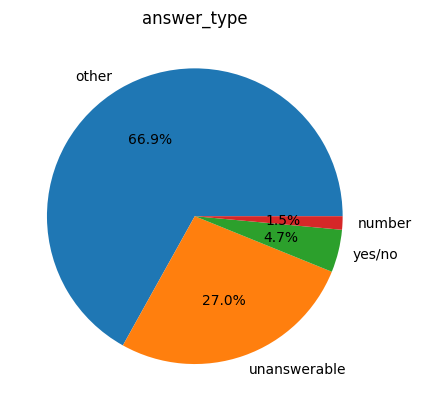

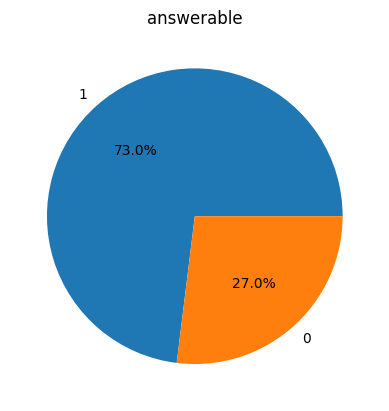

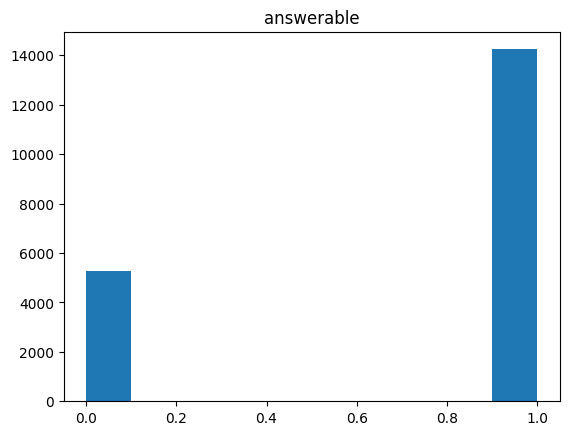

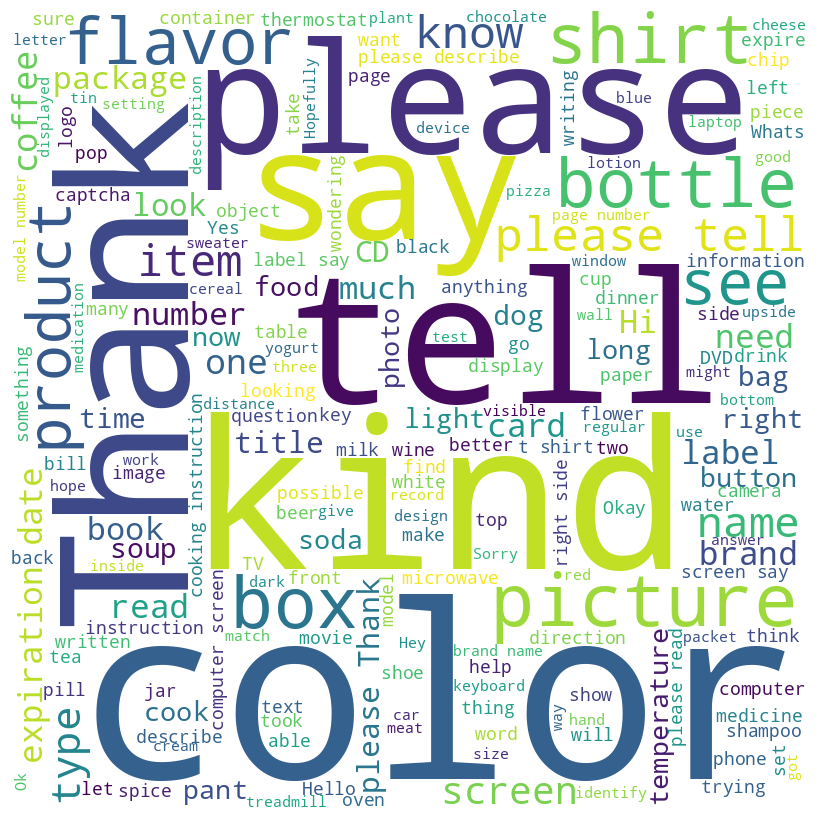

In [30]:
print("Number of distinct answers: ", get_number_of_distinct_answers(train_df))
print("Number of samples in train: ", len(train_df))
explore_dataframe(train_df)

### Validation Data

Number of distinct answers:  10905
Number of samples in validation set:  4319


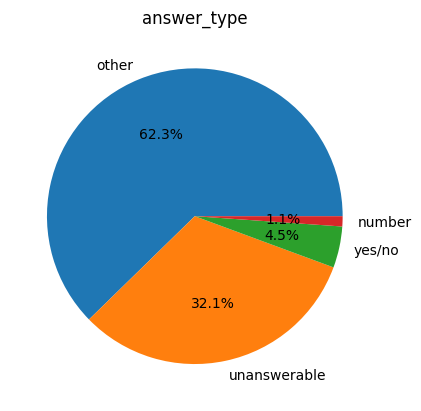

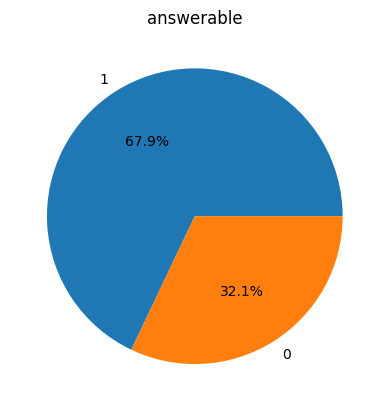

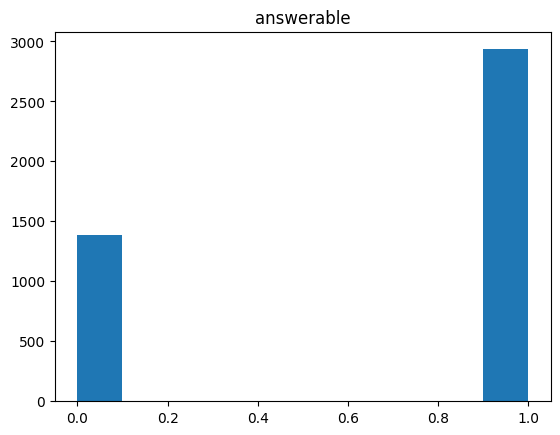

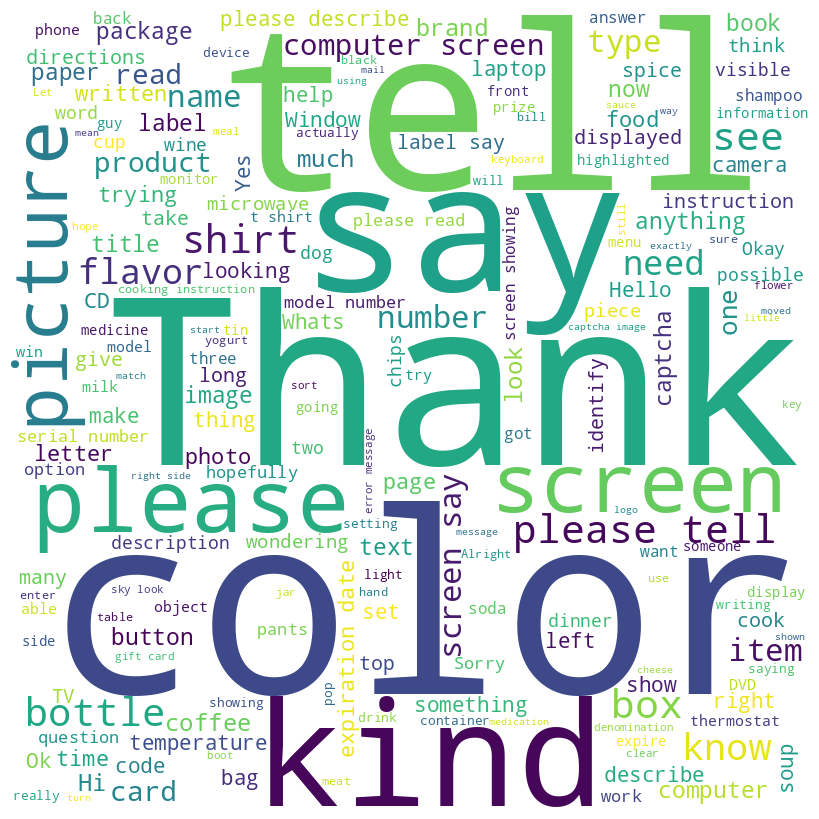

In [31]:
print("Number of distinct answers: ", get_number_of_distinct_answers(validation_df))
print("Number of samples in validation set: ", len(validation_df))
explore_dataframe(validation_df)

### Test Data

Number of distinct answers:  3007
Number of samples in test:  1027


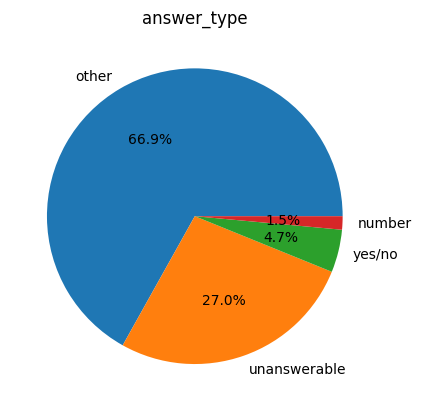

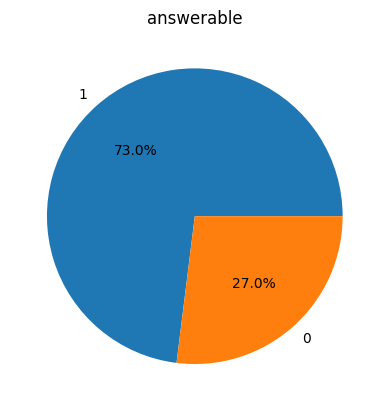

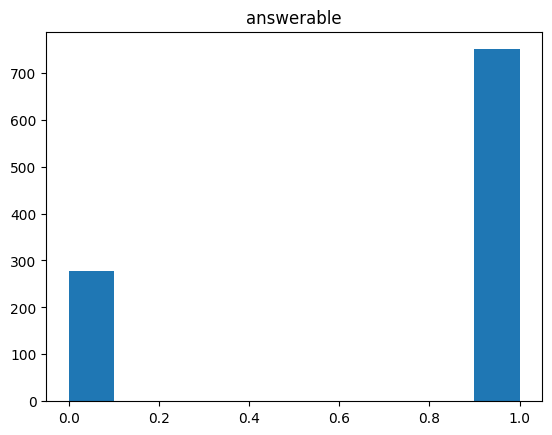

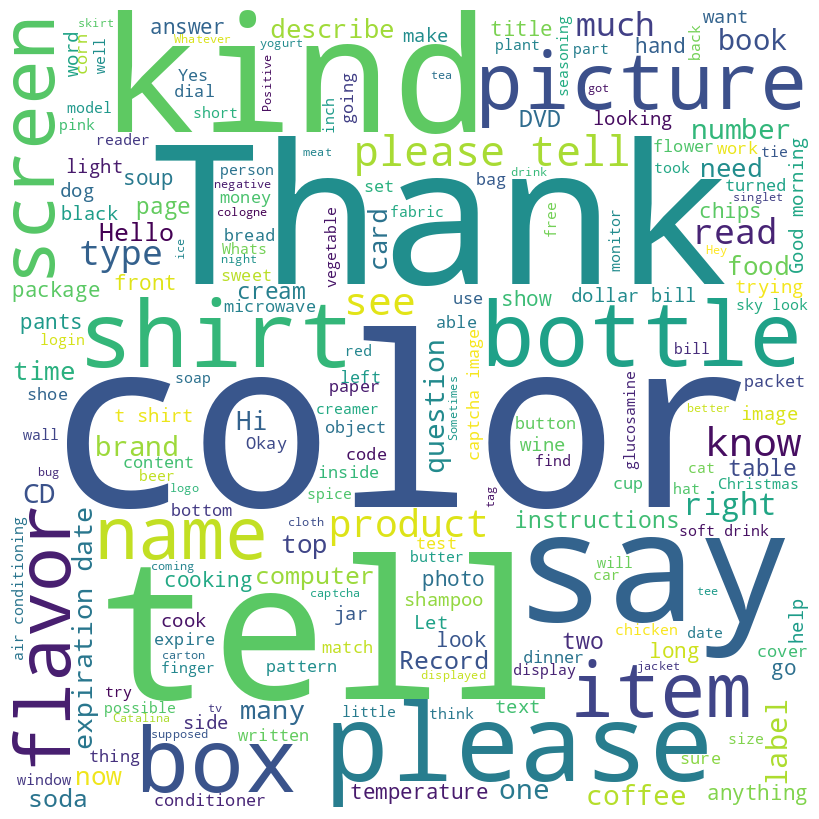

In [32]:
print("Number of distinct answers: ", get_number_of_distinct_answers(test_df))
print("Number of samples in test: ", len(test_df))
explore_dataframe(test_df)

## VQA Dataset

In [33]:
ANNOTATIONS_PATH = '/content/drive/MyDrive/9444/Dataset/merged_data.json'
IMG_DIR = '/content/drive/MyDrive/9444/Dataset/val2014'
OUTPUT_PATH = '/content/drive/MyDrive/9444/Training_output/'

In [34]:
train_df = read_dataframe(ANNOTATIONS_PATH)
# validation_df = read_dataframe(ANNOTATIONS_VAL_PATH) # TODO
train_df, valid_df, test_df = split_train_valid_test(train_df)
ANSWER_SPACE = get_number_of_distinct_answers(train_df) # The answer space will be decreased later when we process the answers
print("Number of distinct answers: ", ANSWER_SPACE)

Number of distinct answers:  72683


### Training Data

Number of distinct answers:  72683
Number of samples in train:  150047


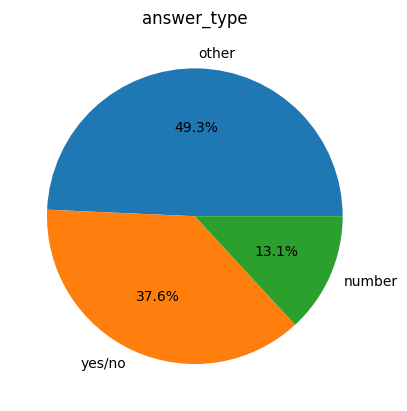

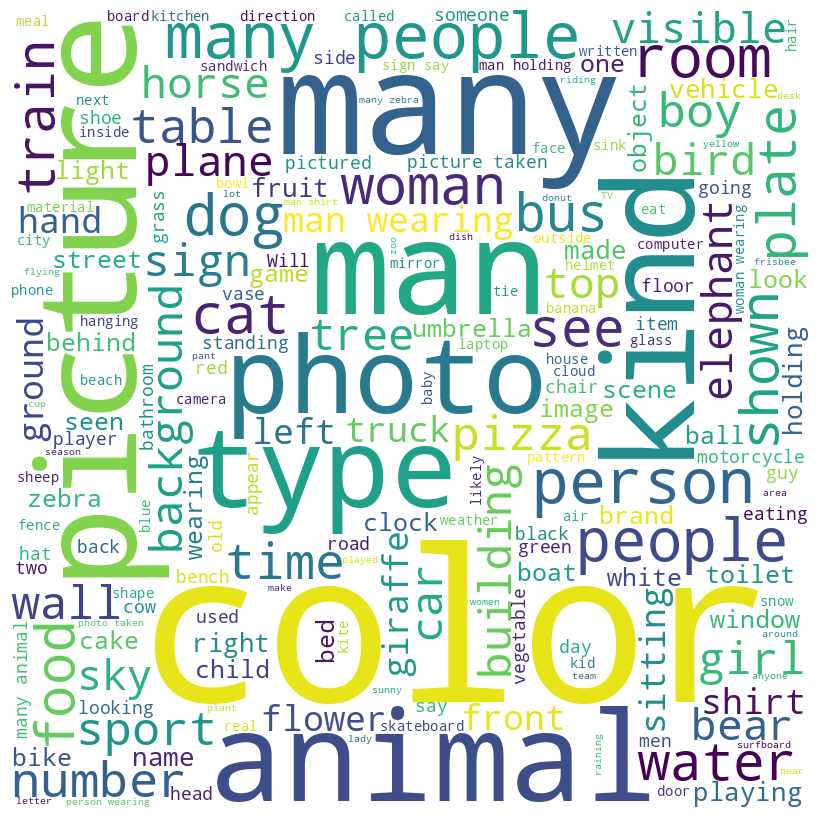

In [35]:
print("Number of distinct answers: ", get_number_of_distinct_answers(train_df))
print("Number of samples in train: ", len(train_df))
explore_dataframe_vqa(train_df)

### Validation Data

Number of distinct answers:  28778
Number of samples in validation set:  42871


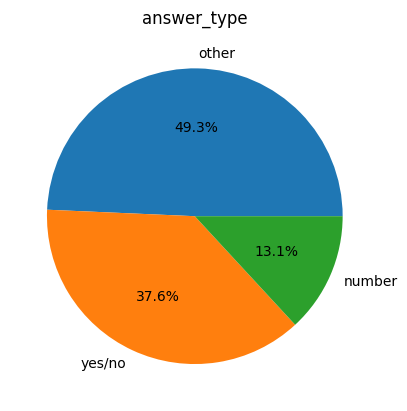

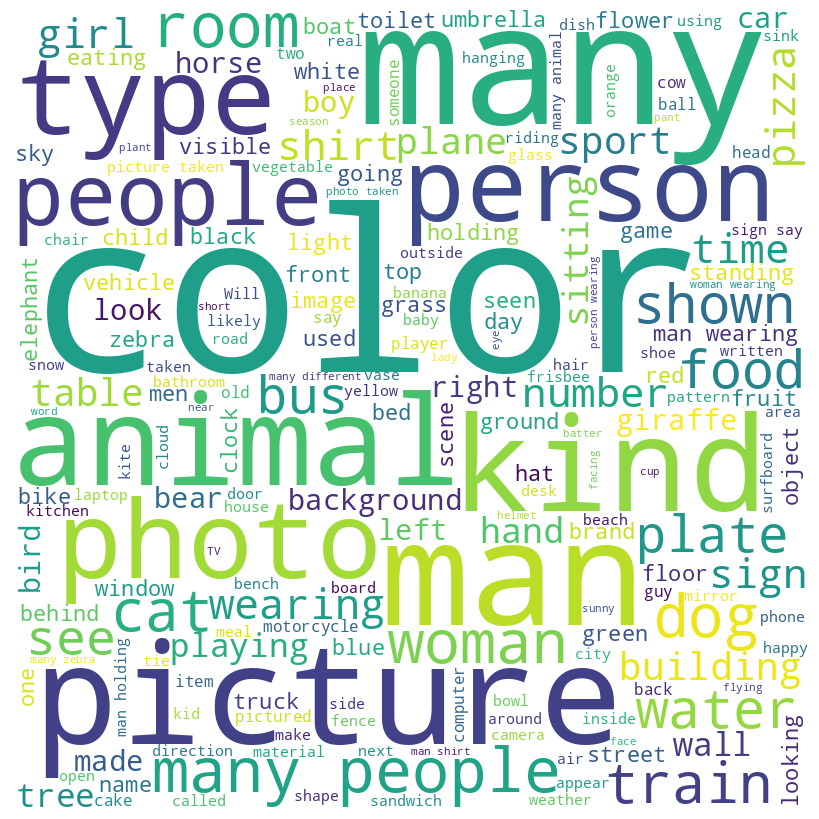

In [36]:
print("Number of distinct answers: ", get_number_of_distinct_answers(valid_df))
print("Number of samples in validation set: ", len(valid_df))
explore_dataframe_vqa(valid_df)

### Test Data

Number of distinct answers:  17080
Number of samples in test:  21436


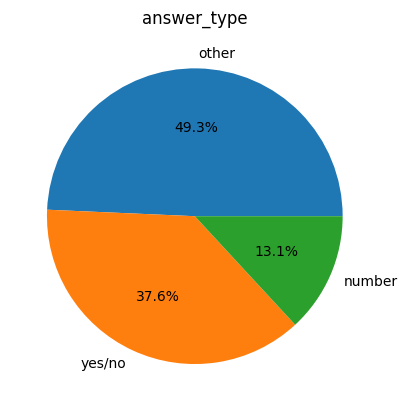

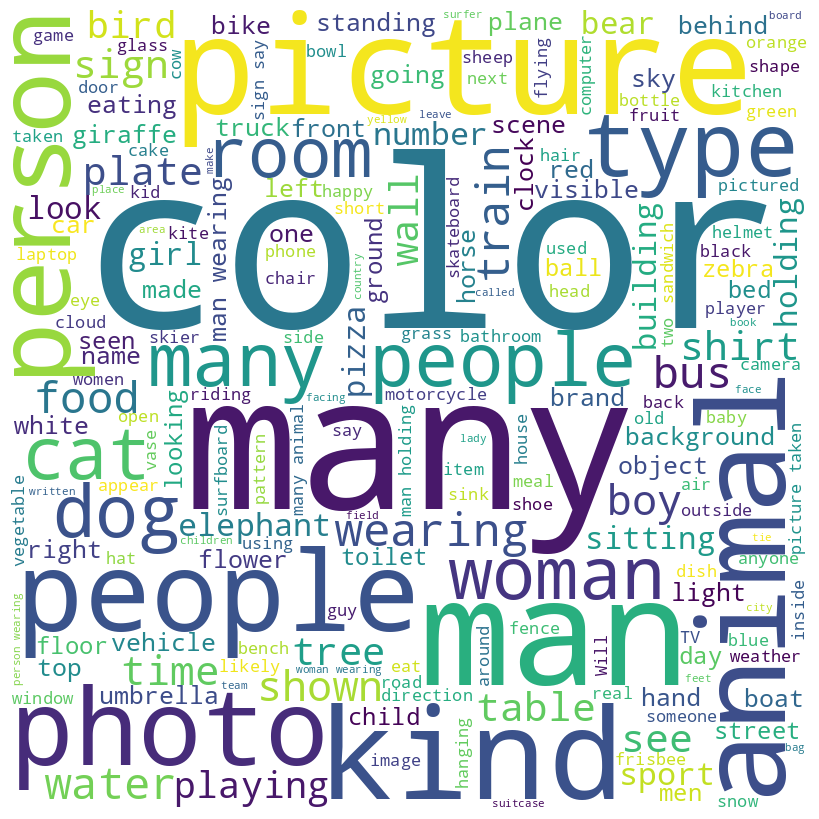

In [37]:
print("Number of distinct answers: ", get_number_of_distinct_answers(test_df))
print("Number of samples in test: ", len(test_df))
explore_dataframe_vqa(test_df)